<a href="https://colab.research.google.com/github/torpedo-jamie/Xente-Fraud-Detection-Challenge/blob/master/Xente_Fraud_Detection_Challenge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [164]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [0]:
# importing necessary modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from imblearn.over_sampling import SMOTE

import warnings
warnings.filterwarnings("ignore")

# Loading train and test data

In [0]:
# importing train and test data from my google drive
train = pd.read_csv('/gdrive/My Drive/XenteChallenge/training.csv')
test = pd.read_csv('/gdrive/My Drive/XenteChallenge/test.csv')

In [410]:
train.head()

,TransactionId,BatchId,AccountId,SubscriptionId,CustomerId,CurrencyCode,CountryCode,ProviderId,ProductId,ProductCategory,ChannelId,Amount,Value,TransactionStartTime,PricingStrategy,FraudResult
0,TransactionId_76871,BatchId_36123,AccountId_3957,SubscriptionId_887,CustomerId_4406,UGX,256,ProviderId_6,ProductId_10,airtime,ChannelId_3,1000.0,1000,2018-11-15T02:18:49Z,2,0
1,TransactionId_73770,BatchId_15642,AccountId_4841,SubscriptionId_3829,CustomerId_4406,UGX,256,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-20.0,20,2018-11-15T02:19:08Z,2,0
2,TransactionId_26203,BatchId_53941,AccountId_4229,SubscriptionId_222,CustomerId_4683,UGX,256,ProviderId_6,ProductId_1,airtime,ChannelId_3,500.0,500,2018-11-15T02:44:21Z,2,0
3,TransactionId_380,BatchId_102363,AccountId_648,SubscriptionId_2185,CustomerId_988,UGX,256,ProviderId_1,ProductId_21,utility_bill,ChannelId_3,20000.0,21800,2018-11-15T03:32:55Z,2,0
4,TransactionId_28195,BatchId_38780,AccountId_4841,SubscriptionId_3829,CustomerId_988,UGX,256,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-644.0,644,2018-11-15T03:34:21Z,2,0


In [411]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95662 entries, 0 to 95661
Data columns (total 16 columns):
TransactionId           95662 non-null object
BatchId                 95662 non-null object
AccountId               95662 non-null object
SubscriptionId          95662 non-null object
CustomerId              95662 non-null object
CurrencyCode            95662 non-null object
CountryCode             95662 non-null int64
ProviderId              95662 non-null object
ProductId               95662 non-null object
ProductCategory         95662 non-null object
ChannelId               95662 non-null object
Amount                  95662 non-null float64
Value                   95662 non-null int64
TransactionStartTime    95662 non-null object
PricingStrategy         95662 non-null int64
FraudResult             95662 non-null int64
dtypes: float64(1), int64(4), object(11)
memory usage: 11.7+ MB


As we can see, there are 95662 rows and 16 columns. Fortunately there are no missing values so there is no need to fill in any missing values.

# Data Processing

Our y value is the FraudResult variable. This variable tells us whether a fraudulent transaction took place or not. The result in this column is 1 if a fraudulent transaction took place and 0 if not.

In [0]:
y = train['FraudResult']

I've decided to drop a few columns and keep the following columns: 'ProviderId', 'ProductId', 'ProductCategory', 'ChannelId', 'Amount', 'Value', 'PricingStrategy'. I dropped columns that were id columns and columns that only had one unique value in all the rows.

In [0]:
X = train[['ProviderId', 'ProductId', 'ProductCategory', 'ChannelId', 'Amount', 'Value', 'PricingStrategy']]

**Looking at the distribustion of ProviderId** 

In [0]:
sns.set(style="darkgrid")

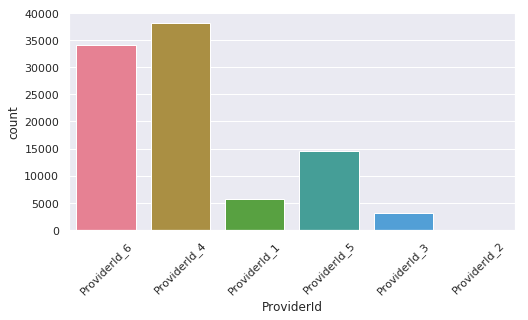

In [415]:
plt.figure(figsize=[8,4])
sns.countplot(x='ProviderId', data=X, palette='husl')
plt.xticks(rotation=45)
plt.show()

**Looking at the distribustion of ProductId** 

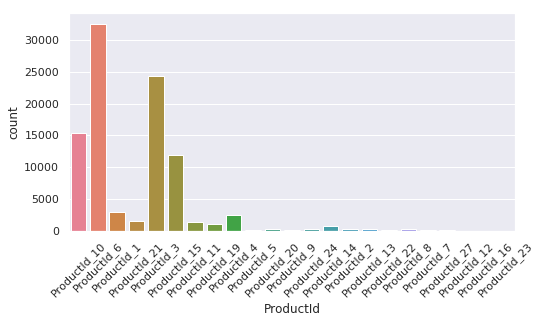

In [416]:
plt.figure(figsize=[8,4])
sns.countplot(x='ProductId', data=X, palette='husl')
plt.xticks(rotation=45)
plt.show()

**Looking at the distribustion of ProductCategory** 

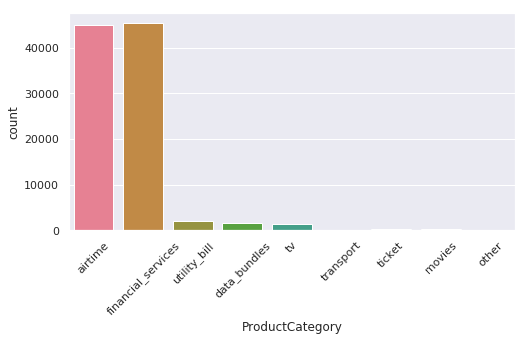

In [417]:
plt.figure(figsize=[8,4])
sns.countplot(x='ProductCategory', data=X, palette='husl')
plt.xticks(rotation=45)
plt.show()

**Looking at the distribustion of ChannelId** 

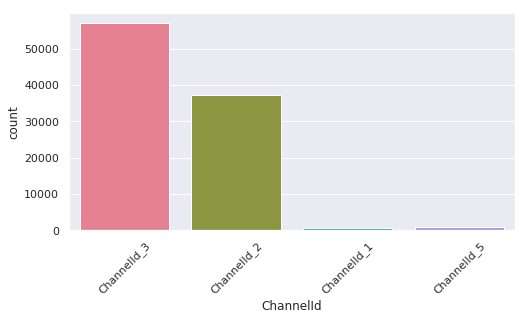

In [418]:
plt.figure(figsize=[8,4])
sns.countplot(x='ChannelId', data=X, palette='husl')
plt.xticks(rotation=45)
plt.show()

**Looking at the distribustion of PriceStrategy** 

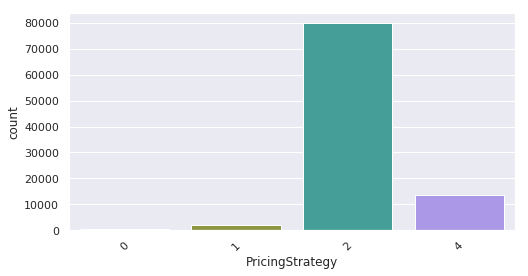

In [419]:
plt.figure(figsize=[8,4])
sns.countplot(x='PricingStrategy', data=X, palette='husl')
plt.xticks(rotation=45)
plt.show()

# Encoding Categories

Looking at the number of unique values in the train dataset and the number of unique values in the test dataset to see if one contains more or less of the other.

In [422]:
unique_vals = pd.DataFrame(index=train.columns, columns=['No. unique values'], data=train.nunique().get_values())
unique_vals

,No. unique values
TransactionId,95662
BatchId,94809
AccountId,3633
SubscriptionId,3627
CustomerId,3742
CurrencyCode,1
CountryCode,1
ProviderId,6
ProductId,23
ProductCategory,9


In [423]:
test_unique_vals = pd.DataFrame(index=test.columns, columns=['No. unique values'], data=test.nunique().get_values())
test_unique_vals

,No. unique values
TransactionId,45019
BatchId,44684
AccountId,2471
SubscriptionId,2470
CustomerId,5018
CurrencyCode,1
CountryCode,1
ProviderId,6
ProductId,26
ProductCategory,9


The test dataset has 3 addition product id's and 1 additional channel id. Let's see which those are and add them to our train dataset.

**ProductId unique values**

In [428]:
train['ProductId'].unique()

array(['ProductId_10', 'ProductId_6', 'ProductId_1', 'ProductId_21',
       'ProductId_3', 'ProductId_15', 'ProductId_11', 'ProductId_19',
       'ProductId_4', 'ProductId_5', 'ProductId_20', 'ProductId_9',
       'ProductId_24', 'ProductId_14', 'ProductId_2', 'ProductId_13',
       'ProductId_22', 'ProductId_8', 'ProductId_7', 'ProductId_27',
       'ProductId_12', 'ProductId_16', 'ProductId_23'], dtype=object)

In [429]:
test['ProductId'].unique()

array(['ProductId_3', 'ProductId_15', 'ProductId_6', 'ProductId_10',
       'ProductId_14', 'ProductId_1', 'ProductId_7', 'ProductId_4',
       'ProductId_21', 'ProductId_8', 'ProductId_11', 'ProductId_19',
       'ProductId_13', 'ProductId_24', 'ProductId_22', 'ProductId_20',
       'ProductId_27', 'ProductId_2', 'ProductId_9', 'ProductId_26',
       'ProductId_5', 'ProductId_25', 'ProductId_18', 'ProductId_17',
       'ProductId_16', 'ProductId_23'], dtype=object)

So it looks like there are no transactions with ProductId_17, ProductId_18, ProductId_25, ProductId_26 in the train set. We can also see that the test set does not contain a case with ProductId_12.

**ChannelId unique values**

In [430]:
train['ChannelId'].unique()

array(['ChannelId_3', 'ChannelId_2', 'ChannelId_1', 'ChannelId_5'],
      dtype=object)

In [431]:
test['ChannelId'].unique()

array(['ChannelId_3', 'ChannelId_2', 'ChannelId_5', 'ChannelId_1',
       'ChannelId_4'], dtype=object)

As we can see there are no transactions with ChannelId4 in the train set.

**ProductCategory unique values**

In [432]:
train['ProductCategory'].unique()

array(['airtime', 'financial_services', 'utility_bill', 'data_bundles',
       'tv', 'transport', 'ticket', 'movies', 'other'], dtype=object)

In [433]:
test['ProductCategory'].unique()

array(['airtime', 'financial_services', 'tv', 'utility_bill',
       'data_bundles', 'movies', 'ticket', 'retail', 'transport'],
      dtype=object)

There are no transactions with 'other' product category in the test set and there are notransactions with 'retail' product category in the train set.

In [0]:
X = pd.get_dummies(X, drop_first=True)

In [0]:
X['ProductId_ProductId_17'] = 0
X['ProductId_ProductId_18'] = 0
X['ProductId_ProductId_25'] = 0
X['ProductId_ProductId_26'] = 0
X['ChannelId_ChannelId_4'] = 0
X['ProductCategory_retail'] = 0

Fixing the layout of the final X dataframe so that it is in order.

In [0]:
X = X[['Amount', 'Value', 'PricingStrategy', 'ProviderId_ProviderId_2', 'ProviderId_ProviderId_3', 'ProviderId_ProviderId_4', 'ProviderId_ProviderId_5', 'ProviderId_ProviderId_6',
         'ProductId_ProductId_10', 'ProductId_ProductId_11', 'ProductId_ProductId_12', 'ProductId_ProductId_13', 'ProductId_ProductId_14', 'ProductId_ProductId_15', 'ProductId_ProductId_16',
         'ProductId_ProductId_17', 'ProductId_ProductId_18', 'ProductId_ProductId_19', 'ProductId_ProductId_2', 'ProductId_ProductId_20', 'ProductId_ProductId_21', 'ProductId_ProductId_22', 
         'ProductId_ProductId_23', 'ProductId_ProductId_24', 'ProductId_ProductId_25', 'ProductId_ProductId_26', 'ProductId_ProductId_27', 'ProductCategory_data_bundles', 
         'ProductCategory_financial_services', 'ProductCategory_movies', 'ProductCategory_other', 'ProductCategory_ticket', 'ProductCategory_transport', 'ProductCategory_tv', 
         'ProductCategory_utility_bill', 'ProductCategory_retail', 'ChannelId_ChannelId_2', 'ChannelId_ChannelId_3', 'ChannelId_ChannelId_4', 'ChannelId_ChannelId_5']]

**Splitting the data into a train and test set**

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8, random_state=42)

**Looking at the distribution of the target variable**

We can see that almost all transactions are marked as not fraudulent. There are only a few cases of fraudulent transactions.

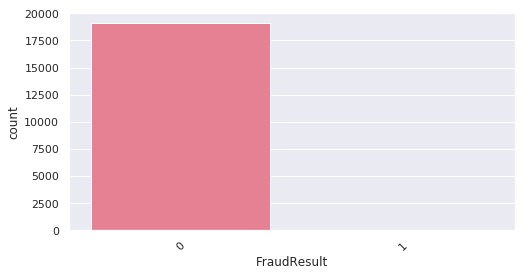

In [438]:
plt.figure(figsize=[8,4])
sns.countplot(x=y_train, palette='husl')
plt.xticks(rotation=45)
plt.show()

# Building models before resampling

**Logistic Regression model before resampling data**

In [439]:
log_reg = LogisticRegression()
params = {'C': [0.001, 0.01, 0.1, 1.0],
          'solver': ['liblinear', 'sag', 'saga']}
clf_logreg = GridSearchCV(estimator=log_reg, param_grid=params, n_jobs=-1)
clf_logreg.fit(X_train, y_train)

GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='warn',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='warn',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'C': [0.001, 0.01, 0.1, 1.0],
                         'solver': ['liblinear', 'sag', 'saga']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [440]:
clf_logreg.best_params_

{'C': 0.01, 'solver': 'liblinear'}

In [0]:
y_pred_lgrg = clf_logreg.predict(X_test)

In [442]:
print('Accuracy:', accuracy_score(y_test, y_pred_lgrg))

Accuracy: 0.998405853913498


In [443]:
print('F1_score:', f1_score(y_test, y_pred_lgrg))

F1_score: 0.46491228070175433


**Random Forest model before resampling data**

In [444]:
ran_for = RandomForestClassifier()
params = {'n_estimators': [2, 5, 10, 15],
          'max_depth': [None, 2, 5, 8, 10, 20],
          'max_features': ['auto', 'sqrt', 'log2', None],
          #'n_jobs': [1, -1],
          'random_state': [None, 42]}
clf_forest = GridSearchCV(estimator=ran_for, param_grid=params, n_jobs=-1)
clf_forest.fit(X_train, y_train)

GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                                              warm_start=False),
           

In [445]:
clf_forest.best_params_

{'max_depth': None,
 'max_features': None,
 'n_estimators': 5,
 'random_state': None}

In [0]:
y_pred_forest = clf_forest.predict(X_test)

In [447]:
print('Accuracy:', accuracy_score(y_test, y_pred_forest))

Accuracy: 0.9993858617535607


In [448]:
print('F1_score:', f1_score(y_test, y_pred_forest))

F1_score: 0.8327402135231317


# Building models after resampling

I've decided to use imblearn's Synthetic Minority Oversampling Technique to upsample my minority data class, 1 in this case.

In [0]:
sm = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = sm.fit_sample(X_train, y_train)

We can see that the classes are evenly distributed now.

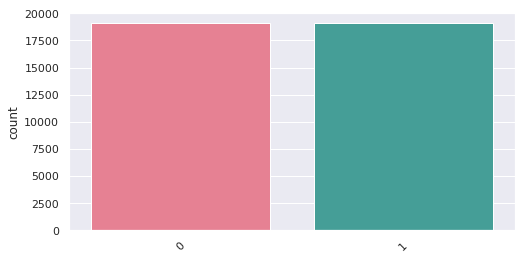

In [451]:
plt.figure(figsize=[8,4])
sns.countplot(x=y_train_resampled, palette='husl')
plt.xticks(rotation=45)
plt.show()

**Logistic Regression model after resampling data**

In [452]:
log_reg = LogisticRegression()
params = {'C': [0.001, 0.01, 0.1, 1.0],
         'solver': ['liblinear', 'sag', 'saga']}
clf_logreg_resample = GridSearchCV(estimator=log_reg, param_grid=params, n_jobs=-1)
clf_logreg_resample.fit(X_train_resampled, y_train_resampled)

GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='warn',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='warn',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'C': [0.001, 0.01, 0.1, 1.0],
                         'solver': ['liblinear', 'sag', 'saga']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [453]:
clf_logreg_resample.best_params_

{'C': 0.001, 'solver': 'liblinear'}

In [0]:
y_pred_lgrg_resample = clf_logreg_resample.predict(X_test)

In [455]:
print('Accuracy:', accuracy_score(y_test, y_pred_lgrg_resample))

Accuracy: 0.0019992159937279497


In [456]:
print('F1_score:', f1_score(y_test, y_pred_lgrg_resample))

F1_score: 0.003990454207581863


The model performed even worse than before the resampling of the data was done.

**Random Forest model after resampling data**

In [351]:
ran_for = RandomForestClassifier()
params = {'n_estimators': [2, 5, 10, 15],
          'max_depth': [None, 2, 5, 8, 10],
          'max_features': ['auto', 'sqrt', 'log2', None],
          'n_jobs': [1, -1],
          'random_state': [None, 42]}
clf_forest_resample = GridSearchCV(estimator=ran_for, param_grid=params, n_jobs=-1)
clf_forest_resample.fit(X_train_resampled, y_train_resampled)

GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                                              warm_start=False),
           

In [0]:
y_pred_forest_resample = clf_forest_resample.predict(X_test)

In [353]:
print('Accuracy:', accuracy_score(y_test, y_pred_forest))

Accuracy: 0.9994773291519665


In [354]:
print('F1_score:', f1_score(y_test, y_pred_forest_resample))

F1_score: 0.6473429951690821


Again the models accuracy declined after resampling was done.

# Preprocessing test data

In [301]:
test.head()

,TransactionId,BatchId,AccountId,SubscriptionId,CustomerId,CurrencyCode,CountryCode,ProviderId,ProductId,ProductCategory,ChannelId,Amount,Value,TransactionStartTime,PricingStrategy
0,TransactionId_50600,BatchId_35028,AccountId_2441,SubscriptionId_4426,CustomerId_2857,UGX,256,ProviderId_5,ProductId_3,airtime,ChannelId_3,1000.0,1000,2019-02-13T10:01:40Z,4
1,TransactionId_95109,BatchId_45139,AccountId_3439,SubscriptionId_2643,CustomerId_3874,UGX,256,ProviderId_5,ProductId_15,financial_services,ChannelId_3,2000.0,2000,2019-02-13T10:02:12Z,2
2,TransactionId_47357,BatchId_74887,AccountId_4841,SubscriptionId_3829,CustomerId_2857,UGX,256,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-50.0,50,2019-02-13T10:02:30Z,2
3,TransactionId_28185,BatchId_11025,AccountId_2685,SubscriptionId_4626,CustomerId_3105,UGX,256,ProviderId_5,ProductId_10,airtime,ChannelId_3,3000.0,3000,2019-02-13T10:02:38Z,4
4,TransactionId_22140,BatchId_29804,AccountId_4841,SubscriptionId_3829,CustomerId_3105,UGX,256,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-60.0,60,2019-02-13T10:02:58Z,2


In [302]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45019 entries, 0 to 45018
Data columns (total 15 columns):
TransactionId           45019 non-null object
BatchId                 45019 non-null object
AccountId               45019 non-null object
SubscriptionId          45019 non-null object
CustomerId              45019 non-null object
CurrencyCode            45019 non-null object
CountryCode             45019 non-null int64
ProviderId              45019 non-null object
ProductId               45019 non-null object
ProductCategory         45019 non-null object
ChannelId               45019 non-null object
Amount                  45019 non-null float64
Value                   45019 non-null int64
TransactionStartTime    45019 non-null object
PricingStrategy         45019 non-null int64
dtypes: float64(1), int64(3), object(11)
memory usage: 5.2+ MB


In [0]:
test_final = test[['ProviderId', 'ProductId', 'ProductCategory', 'ChannelId', 'Amount', 'Value', 'PricingStrategy']]

In [0]:
test_final = pd.get_dummies(test_final, drop_first=True)

We saw earlier that the test data did not include ProductCategory_other and ProductId12, so we're adding it here now.

In [0]:
test_final['ProductCategory_other'] = 0

In [0]:
test_final['ProductId_ProductId_12'] = 0

In [0]:
test_final = test_final[['Amount', 'Value', 'PricingStrategy', 'ProviderId_ProviderId_2', 'ProviderId_ProviderId_3', 'ProviderId_ProviderId_4', 'ProviderId_ProviderId_5', 'ProviderId_ProviderId_6',
         'ProductId_ProductId_10', 'ProductId_ProductId_11', 'ProductId_ProductId_12', 'ProductId_ProductId_13', 'ProductId_ProductId_14', 'ProductId_ProductId_15', 'ProductId_ProductId_16',
         'ProductId_ProductId_17', 'ProductId_ProductId_18', 'ProductId_ProductId_19', 'ProductId_ProductId_2', 'ProductId_ProductId_20', 'ProductId_ProductId_21', 'ProductId_ProductId_22', 
         'ProductId_ProductId_23', 'ProductId_ProductId_24', 'ProductId_ProductId_25', 'ProductId_ProductId_26', 'ProductId_ProductId_27', 'ProductCategory_data_bundles', 
         'ProductCategory_financial_services', 'ProductCategory_movies', 'ProductCategory_other', 'ProductCategory_ticket', 'ProductCategory_transport', 'ProductCategory_tv', 
         'ProductCategory_utility_bill', 'ProductCategory_retail', 'ChannelId_ChannelId_2', 'ChannelId_ChannelId_3', 'ChannelId_ChannelId_4', 'ChannelId_ChannelId_5']]

# Making predictions

In [0]:
final_predictions = clf_forest.predict(test_final)

# Submission

In [0]:
submission = pd.DataFrame(columns=['TransactionId', 'FraudResult'])

In [0]:
submission['TransactionId'] = test['TransactionId']

In [0]:
submission['FraudResult'] = final_predictions

In [347]:
submission.head()

,TransactionId,FraudResult
0,TransactionId_50600,0
1,TransactionId_95109,0
2,TransactionId_47357,0
3,TransactionId_28185,0
4,TransactionId_22140,0


In [0]:
submission.to_csv('RandomForest.csv', index=False)

# Downloading final submission file

In [0]:
from google.colab import files

In [0]:
files.download('RandomForest.csv')